In [1]:
#imports
import math
#PyTorch imports
import torch
import torch.nn as nn
from torch.optim import AdamW
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Import SciPy to load the Flowers-102 dataset from the .mat format
import scipy.io

#Other imports
import numpy as np
import matplotlib.pyplot as plt

#Import time so that we can train the model within the 12 hour time limit
import time

In [2]:
#Define transforms
trainingTransform = transforms.Compose([
    transforms.Resize(224), #Change this value to edit the image size
    transforms.CenterCrop(224), #Must be the same as resize value. This is used to ensure the image is square
    #Default probability for both flips is p=0.5, can be changed if needed
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #Rotates each image by a random angle between 0-90 degrees
    transforms.RandomRotation(180),
    #TODO: Find out how to apply this transformation randomly
    # (note from Olivia, use the range! satruation can go High but
    # then the images look weird, hsue has to be between -0.5-0.5)
    transforms.ColorJitter(saturation=[0, 5], hue=(-0.25, 0.25)),
    transforms.ToTensor(),
    transforms.Normalize(0,1) #zerocenter normalization
])

nonTrainTransform = transforms.Compose([
    #Same as training transform without flipping as required
    #by assessment rules
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

#Load Flowers-102 dataset and split it into train, validate and test splits
trainingSet = datasets.Flowers102(root="./flowers", split="train", download=True, transform=trainingTransform)
validationSet = datasets.Flowers102(root="./flowers", split="val", download=True, transform=nonTrainTransform)
testingSet = datasets.Flowers102(root="./flowers", split="test", download=True, transform=nonTrainTransform)

100%|██████████| 344862509/344862509 [00:01<00:00, 189168078.56it/s]


Extracting flowers/flowers-102/102flowers.tgz to flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1598740.02it/s]


100%|██████████| 14989/14989 [00:00<00:00, 36765159.45it/s]


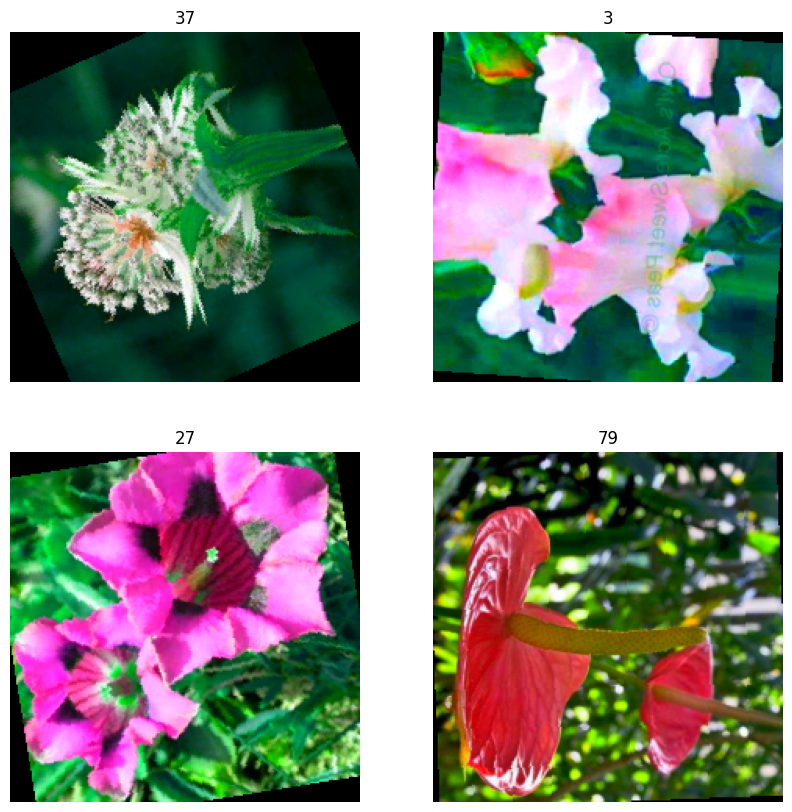

In [3]:
#Checking the training transformations are ok
figure = plt.figure(figsize=(10,10))
col, row = 2, 2
for i in range(1, 5): #TODO: Change this to be rows * columns
  randImg = torch.randint(len(trainingSet), size=(1,)).item() #Size defines the shape of the tensor
  img, label = trainingSet[randImg]
  figure.add_subplot(row, col, i)
  plt.title(label)
  plt.axis(False)
  plt.imshow(img.squeeze().permute(1,2,0)) #Permute gets the dimentions in the correct order
plt.show()

In [4]:
#Checking if colab can connect to a GPU
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [11]:
#The CNN itself
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    #DEFINING THE LAYERS. THIS IS WHERE WE WILL SPEND MOST OF OUR TIME
    self.netLayers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.AvgPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(256),
        #nn.LeakyReLU(), #LeakyReLU is used to prevent 'dead ReLU' issues
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        #IMPORTANT: in channels for first linear must be
        # (image size) * (image size) * C
        #Where C is the out channels of the last conv2d
        #If confused, just print out the shape of the matrix
        nn.Linear(100352, 128),
        nn.BatchNorm1d(128),
        nn.Linear(128, 64),
        nn.Dropout(0.15),
        #nn.Linear(128, 32),
        nn.Linear(64, 102), #102 for the classifiers
        nn.LogSoftmax(dim=1)
    )
  
  def forward(self, x):
      result = self.netLayers(x)
      #print(result.shape)
      return result
  


In [6]:
#Code to train the CNN based on a set number of epochs
def epochCountTrain(trainLoader, cnn, optimizer, lossFunction):
  totalLoss, correct = 0, 0
  lossList = []
  size = len(trainLoader.dataset)
  for i, data in enumerate(trainLoader, 0):
    input, labels = data
    input = input.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = cnn(input)
    loss = lossFunction(output, labels)
    loss.backward()
    optimizer.step()
   

    correct += (output.argmax(1)==labels).sum().item()
    if i % 20 == 0:
      loss, currentLoss = loss.item(), (i + 1) * len(input)
      print(f"loss: {loss:>7f}    [{currentLoss:>5d}/{size:>5d}]")

  epochTrainLoss.append(float(loss))
  epochTrainAccuracy.append(round((correct/1020)*100, 1))
  print(f"\n Avg train loss: {(totalLoss/len(trainLoader)):>8f}")
  print(f"Test accuracy = {((correct/1020) * 100): >0.1f}%")

  #plt.plot(lossList)
  #plt.show()

In [7]:
#Code to guess accuracy based on validation set
def validation(valLoader, cnn, lossFunction):
  valSize = len(valLoader.dataset)
  correct = 0
  loss = []
  with torch.no_grad(): #as we are not calling backward, use no grad to save memory
    for batch in valLoader:
      input, labels = batch
      input = input.to(device)
      labels = labels.to(device)
      prediciton = cnn(input)
      loss.append(lossFunction(prediciton, labels).item())
      correct += (prediciton.argmax(1) == labels).sum().item()
  
  epochValLoss.append((np.average(loss)))
  epochValAccuracy.append(round((correct/valSize)*100, 1))
  print(f"Accuracy on validation set = {((correct / valSize) * 100):>0.1f}%")
  print(f"Average loss on validation set = {(np.average(loss))}")




In [8]:
#Code that gets the accuracy of the test set
def test(testLoader, cnn):
  testSize = len(testLoader.dataset)
  correct = 0
  with torch.no_grad():
    for batch in testLoader:
      input, labels = batch
      input = input.to(device)
      labels = labels.to(device)
      prediciton = cnn(input)
      correct +=(prediciton.argmax(1) == labels).sum().item()
  print("----------------------------------------------------")    
  print(f"Accuracy on test set = {((correct / testSize) * 100):>0.1f}%")
  print("----------------------------------------------------")  



Epoch 0
loss: 4.679540    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 2.4%
Accuracy on validation set = 1.0%
Average loss on validation set = 4.815396577119827


Epoch 1
loss: 4.373520    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 4.4%
Accuracy on validation set = 1.7%
Average loss on validation set = 4.750209420919418


Epoch 2
loss: 4.289392    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 5.6%
Accuracy on validation set = 3.0%
Average loss on validation set = 4.545620322227478


Epoch 3
loss: 4.305881    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 6.5%
Accuracy on validation set = 6.6%
Average loss on validation set = 4.351278126239777


Epoch 4
loss: 4.037211    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 8.8%
Accuracy on validation set = 6.7%
Average loss on validation set = 4.26123771071434


Epoch 5
loss: 4.089690    [   64/ 1020]

 Avg train loss: 0.000000
Test accuracy = 8.8%
Accuracy on validation set = 6.8%
Av

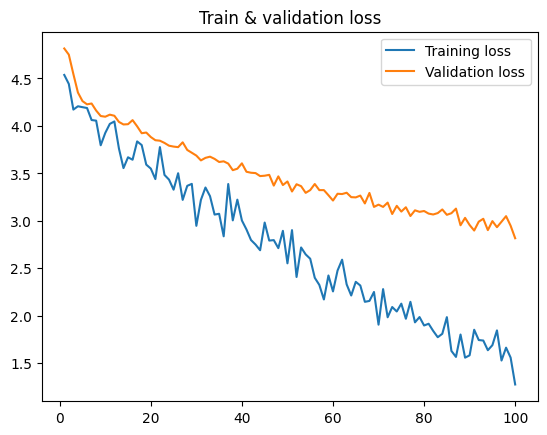

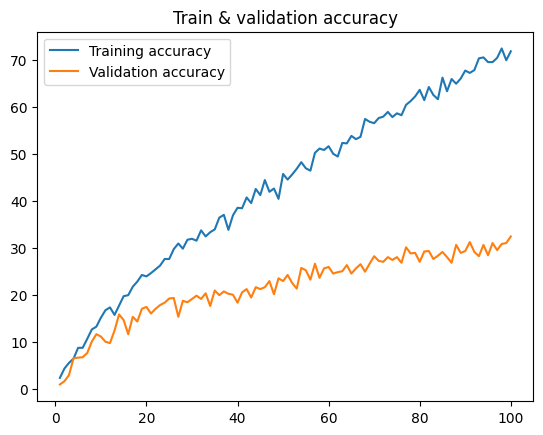

----------------------------------------------------
Accuracy on test set = 32.5%
----------------------------------------------------


In [13]:
#Actual code to get it all running
epochCount = 100
learningRate = 0.00008
batchSize = 64
lossFunction = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = AdamW(lr=learningRate, params=model.parameters())
trainDataloader = DataLoader(trainingSet, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(validationSet, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(validationSet, batch_size=batchSize, shuffle=True)

epochTrainLoss = []
epochTrainAccuracy = []

epochValLoss = []
epochValAccuracy = []

epochCountList = []

for i in range(epochCount):
  print(f"\n\nEpoch {i}")
  model.train()
  epochCountTrain(trainDataloader, model, optimizer, lossFunction)
  model.eval()
  validation(valDataloader, model, lossFunction)

  epochCountList.append(i+1)

plt.plot(epochCountList, epochTrainLoss, label="Training loss")
plt.plot(epochCountList, epochValLoss, label="Validation loss")
plt.title("Train & validation loss")
plt.legend()
plt.show()

plt.plot(epochCountList, epochTrainAccuracy, label="Training accuracy")
plt.plot(epochCountList, epochValAccuracy, label="Validation accuracy")
plt.title("Train & validation accuracy")
plt.legend()
plt.show()

test(testDataloader, model)

In [ ]:
PATH ="./fortyTwoPointOnePercentValAcc.pth"
torch.save(model.state_dict(), PATH)